<a href="https://colab.research.google.com/github/vijaay10/image-classification-model/blob/main/Car_vs_Bike_Classifier_Categorical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle
from google.colab import files
uploaded = files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d utkarshsaxenadn/car-vs-bike-classification-dataset
!unzip -q car-vs-bike-classification-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/utkarshsaxenadn/car-vs-bike-classification-dataset
License(s): CC0-1.0
 77% 79.0M/103M [00:00<00:00, 826MB/s]
100% 103M/103M [00:00<00:00, 815MB/s] 


In [ ]:
import os, shutil
from sklearn.model_selection import train_test_split

dataset_dir = '/content/Car-Bike-Dataset'
output_dir = 'output_dataset'
splits = ['train', 'val', 'test']
for split in splits:
    os.makedirs(os.path.join(output_dir, split), exist_ok=True)
classes = os.listdir(dataset_dir)
for cls in classes:
    for split in splits:
        os.makedirs(os.path.join(output_dir, split, cls), exist_ok=True)
    class_dir = os.path.join(dataset_dir, cls)
    images = os.listdir(class_dir)[:200]
    train_val, test = train_test_split(images, test_size=0.2, random_state=42)
    train, val = train_test_split(train_val, test_size=0.25, random_state=42)
    for img in train:
        shutil.copy(os.path.join(class_dir, img), os.path.join(output_dir, 'train', cls, img))
    for img in val:
        shutil.copy(os.path.join(class_dir, img), os.path.join(output_dir, 'val', cls, img))
    for img in test:
        shutil.copy(os.path.join(class_dir, img), os.path.join(output_dir, 'test', cls, img))
print('✅ Dataset split done.')

✅ Dataset split done.


In [ ]:
from PIL import Image, UnidentifiedImageError
def remove_corrupt_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                path = os.path.join(root, file)
                try:
                    with Image.open(path) as img:
                        img.verify()
                except:
                    print(f'Removed: {path}')
                    os.remove(path)
for split in ['train', 'val', 'test']:
    remove_corrupt_images(os.path.join(output_dir, split))

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (224, 224)
train_gen = ImageDataGenerator(rescale=1./255)
val_test_gen = ImageDataGenerator(rescale=1./255)
train_generator = train_gen.flow_from_directory(output_dir+'/train', target_size=IMG_SIZE, batch_size=32, class_mode='categorical')
val_generator = val_test_gen.flow_from_directory(output_dir+'/val', target_size=IMG_SIZE, batch_size=32, class_mode='categorical')
test_generator = val_test_gen.flow_from_directory(output_dir+'/test', target_size=IMG_SIZE, batch_size=32, class_mode='categorical', shuffle=False)

Found 240 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)
x = Dense(256, activation='relu')(x)
output = Dense(2, activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=output)
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,986 (80.64 MB)

 Trainable params: 6,423,298 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
history = model.fit(train_generator, validation_data=val_generator, epochs=15, callbacks=[early_stop])

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 171s 23s/step - accuracy: 0.6292 - loss: 0.5655 - val_accuracy: 0.8750 - val_loss: 0.2097
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 167s 23s/step - accuracy: 0.9971 - loss: 0.0473 - val_accuracy: 0.9750 - val_loss: 0.0812
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 166s 21s/step - accuracy: 0.9971 - loss: 0.0232 - val_accuracy: 0.9500 - val_loss: 0.0880
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 167s 21s/step - accuracy: 1.0000 - loss: 0.0115 - val_accuracy: 0.9750 - val_loss: 0.0766
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 165s 21s/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 0.9750 - val_loss: 0.0763


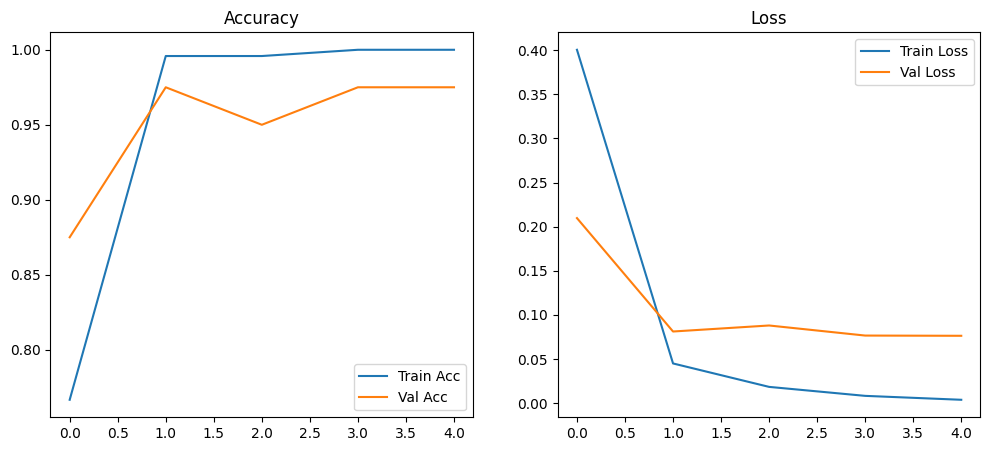

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [ ]:
loss, acc = model.evaluate(test_generator)
print(f'Test Accuracy: {acc:.4f}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 41s 12s/step - accuracy: 0.9539 - loss: 0.1057
Test Accuracy: 0.9625


In [ ]:
model.save('car_vs_bike_model.h5')
print("✅ Model saved as 'car_vs_bike_model.h5'")

✅ Model saved as 'car_vs_bike_model.h5'


In [ ]:
from tensorflow.keras.models import load_model
model = load_model('car_vs_bike_model.h5')

In [ ]:
from google.colab import files
files.download('car_vs_bike_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>